Modules

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from IPython.display import display


Preparing Data

In [3]:
# Load data
prices_df = pd.read_csv('data\Russell3000_prices_clean.csv')
prices_df['Date'] = pd.to_datetime(prices_df['Date'], dayfirst=True)
prices_df.sort_values(by='Date', inplace=True)

# Select stocks to use; exclude the first column (date)
selected_stocks = prices_df.columns[1:51]

# Calculate returns
returns_df = prices_df[selected_stocks].pct_change()
returns_df = returns_df.dropna().reset_index(drop=True)
returns_df.insert(0, 'Date', prices_df['Date'][:-1])

# Convert to numpy array (for later calculations)
returns_matrix = returns_df.iloc[:, 1:].to_numpy()


Defining Parameters

-objasnjenje- train je do starta, test od starta do enda
(godina-mjesec-dan)
min datum je 2000-01-04
max datum je 2021-07-16

In [4]:
global windows, foreacast_horizon, start, end

windows = [21, 63, 126, 252] # month, quarter, half-year, year
forecast_horizon = 21 # trading days
start_date = pd.to_datetime('2000-01-03')
end_date = pd.to_datetime('2021-07-15')

messages = {"start": [], "end": []}

# Check if start_date exists in the DataFrame, if not, take the next date that exists
if start_date not in returns_df['Date'].values:
    start_date = returns_df['Date'][returns_df['Date'] > start_date].bfill().iloc[0]
    messages["start"] = messages["start"] or ['Start date not found, using closest next date instead.']

# Check if end_date exists in the DataFrame, if not, take the previous date that exists
if end_date not in returns_df['Date'].values:
    end_date = returns_df['Date'][returns_df['Date'] < end_date].ffill().iloc[-1]
    messages["end"] = messages["end"] or ['End date not found, using closest date instead.']

start = returns_df.loc[returns_df['Date'] == start_date].index[0]
end = returns_df.loc[returns_df['Date'] == end_date].index[0]

if start < max(windows):
    start = max(windows)
    messages["start"] = messages["start"] or ['Start date too early, not enough data for training.']

if end > len(returns_df) - forecast_horizon:
    end = len(returns_df) - forecast_horizon
    messages["end"] = messages["end"] or ['End date too late, not enough data for testing.']
    
if (end - start) % forecast_horizon != 0:
    end = end - (end - start) % forecast_horizon
    messages["end"] = messages["end"] or ['End date not a multiple of forecast horizon.']

if messages["start"]:
    print('Adjusted start date: {}. Reason: {}'.format(returns_df['Date'][start], ' '.join(messages["start"])))
if messages["end"]:
    print('Adjusted end date: {}. Reason: {}'.format(returns_df['Date'][end], ' '.join(messages["end"])))

del start_date, end_date, messages

Adjusted start date: 2001-01-02 00:00:00. Reason: Start date too early, not enough data for training.
Adjusted end date: 2021-06-04 00:00:00. Reason: End date too late, not enough data for testing.


Naive Risk Parity

-objasnjenje- (inv_volatilities = inverse volatilnosti)

In [5]:
def get_portfolio_weights(volatility):
    inv_volatilities = np.array([1/volatility[stock] if volatility[stock] > 0 else 0 for stock in selected_stocks])
    total = np.sum(inv_volatilities)
    return inv_volatilities / total if total > 0 else np.zeros(len(selected_stocks))

In [6]:
methods = defaultdict(lambda: defaultdict(list))

def gather_portfolio_metrics(method, i, volatility):
    # Record predicted volatility for each stock
    methods[method]["predicted volatility"].extend({stock: [volatility[stock]] for stock in selected_stocks})
        
    # Calculate portfolio weights based on volatility
    weights = get_portfolio_weights(volatility)
    
    # Calculate portfolio returns for each day in the window
    returns = np.dot(returns_matrix[i:i+forecast_horizon], weights)
    
    # Record portfolio returns
    methods[method]["returns"].extend(returns)


Sample Method

In [7]:
method = "Sample"

for window in windows:
    for i in range(start, end, forecast_horizon):
        # 
        volatility = {stock: returns_df[stock][i - window: i].std() for stock in selected_stocks}

        gather_portfolio_metrics(method + "-" + str(window), i, volatility)

Perfect Prediction Method

In [8]:
method = "PerfectPrediction"

for i in range(start, end, forecast_horizon):
    # Trying to predict the volatility of the next forecast_horizon days
    volatility = {stock: returns_df[stock][i: i + forecast_horizon].std() for stock in selected_stocks}

    gather_portfolio_metrics(method, i, volatility)

Equal Weight Method

In this approach, we are assuming that all stocks have the same volatility. This assumption simplifies our model by allowing us to assign equal weights to all stocks in the portfolio. However, it's important to note that this is a simplification. In reality, different stocks may have different volatilities, which could impact the optimal portfolio allocation.

In [9]:
method = "EqualWeight"

for i in range(start, end, forecast_horizon):
    # We assume equal volatility across all stocks, simplifying our model to equal weights.
    volatility = {stock: 1 for stock in selected_stocks}

    gather_portfolio_metrics(method, i, volatility)

Exponential Weight Method

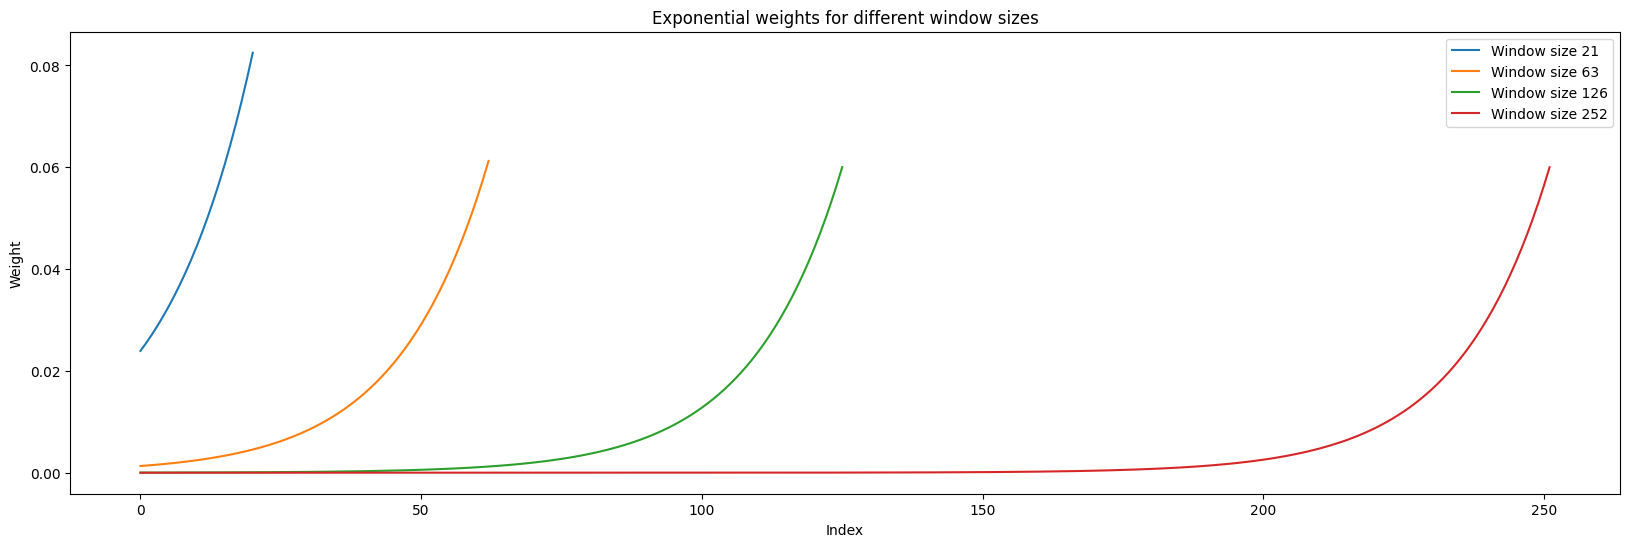

In [16]:
def get_exponential_weights(size, const=0.94):
    weights = [const**i for i in range(size, 0, -1)]
    total = sum(weights)
    return [weight / total for weight in weights]
    
plt.figure(figsize=(20, 6))
for window in windows:
    weights = get_exponential_weights(window)
    plt.plot(weights, label=f'Window size {window}')
plt.title('Exponential weights for different window sizes')
plt.xlabel('Index')
plt.ylabel('Weight')
plt.legend()
plt.show()

In [13]:
method = "ExponentialWeight"

def get_weighted_volatility(weights, returns):
    variance = sum(weights * returns**2)
    return variance**0.5

for window in windows:
    weights = get_exponential_weights(window)
    for i in range(start, end, forecast_horizon):
        # 
        volatility = {stock: get_weighted_volatility(weights, returns_df[stock][i - window: i]) for stock in selected_stocks}

        gather_portfolio_metrics(method + "-" + str(window), i, volatility)

Least Squares Method

In [ ]:
window = 21 # 

def get_lstsq_betas(end):
    A = []
    B = []

    for i in range(0, end - regr_window - 21, 21):
        for stock in selected_stocks:
            A.append(returns_df[stock][i:i + regr_window] ** 2)
            B.append(returns_df[stock][i + regr_window:i + regr_window + 21].var())

    A = np.array(A)  # Convert list of arrays to a single 2D array
    B = np.array(B)  # Convert list of arrays to a single 2D array
    
    X = LinearRegression(positive=True, fit_intercept=False)
    X.fit(A, B)

    return X

X = get_lstsq_betas(start)

Portfolios' Performances

In [17]:
portfolios_df = {
    "Portfolio": [method for method in methods],
    "Std": [np.std(portfolio["returns"]) * 252**0.5 for portfolio in methods.values()],
    "Return": [(1 + np.average(portfolio["returns"]))**252 - 1 for portfolio in methods.values()],
    "Sharpe": [((1 + np.average(portfolio["returns"]))**252 - 1) / (np.std(portfolio["returns"]) * 252**0.5) for portfolio in methods.values()]
}

display(pd.DataFrame(portfolios_df).sort_values('Sharpe', ascending=False).reset_index(drop=True))

,Portfolio,Std,Return,Sharpe
0,Perfect,0.173405,0.148288,0.855152
1,EqWeight,0.200211,0.163768,0.817977
2,Sample-63,0.179718,0.146594,0.815692
3,Sample-252,0.180970,0.146847,0.811444
4,Sample-21,0.179238,0.145381,0.811103
5,Sample-126,0.180253,0.145749,0.808584
6,ExponentialWeight-63,0.179259,0.144911,0.808391
7,ExponentialWeight-126,0.179298,0.144886,0.808070
8,ExponentialWeight-252,0.179299,0.144886,0.808068
9,ExponentialWeight-21,0.179086,0.144686,0.807914


Portfolio Value (initial investment: 1$)

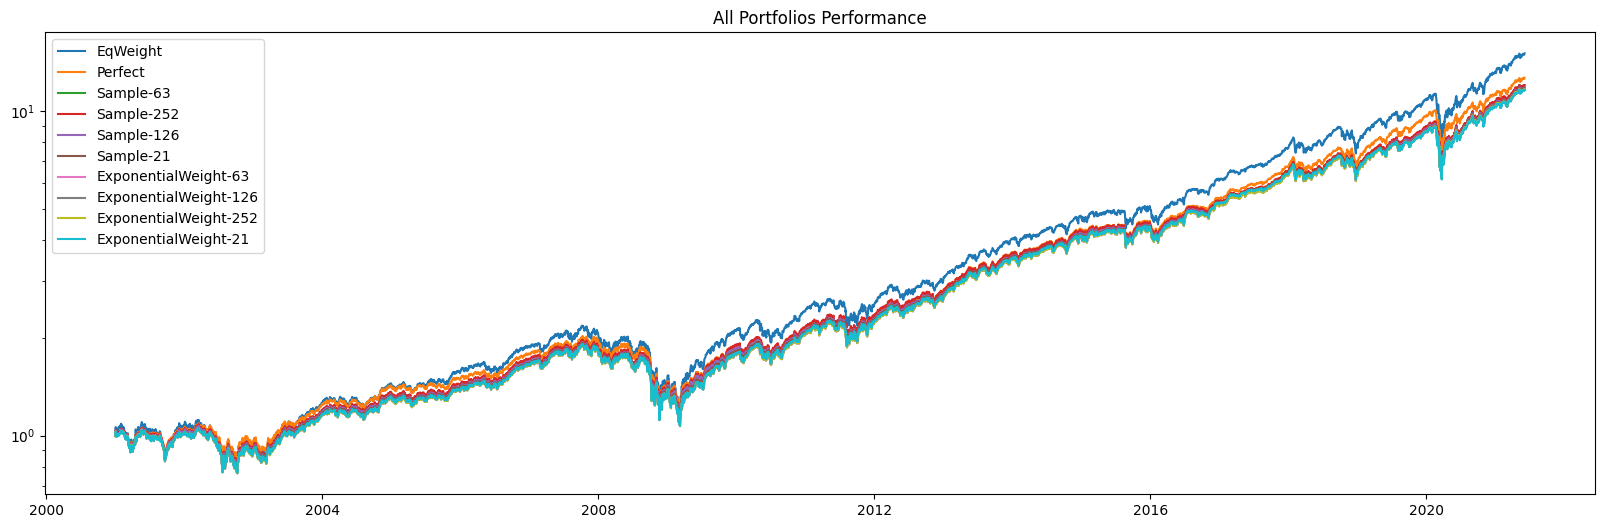

In [18]:
for portfolio in methods.values():
    portfolio["value"] = []
    portfolio["value"].append(1) # Starting value of 1($)
    for ret in portfolio["returns"]:
        portfolio["value"].append((ret+1)*portfolio["value"][-1])

dates = returns_df.iloc[start:end+1, 0]
sorted_methods = sorted(methods.items(), key=lambda method: method[1]["value"][-1], reverse=True)

plt.figure(figsize=(20, 6))
for method, portfolio in sorted_methods:
    plt.semilogy(dates, portfolio["value"], label=method)
plt.title("All Portfolios Performance")
plt.legend()
plt.show()

In [12]:
#del window, i, volatility, method, start, end, forecast_horizon, windows, selected_stocks